In [ ]:
# https://pyriemann.readthedocs.io/en/latest/
# https://neurotechx.github.io/moabb/auto_examples/advanced_examples/plot_statistical_analysis.html#sphx-glr-auto-examples-advanced-examples-plot-statistical-analysis-py

# https://mne.tools/stable/auto_examples/decoding/decoding_csp_timefreq.html?highlight=time_frequency

# https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html#sphx-glr-auto-tutorials-machine-learning-50-decoding-py

# https://mne.tools/stable/auto_tutorials/time-freq/50_ssvep.html#sphx-glr-auto-tutorials-time-freq-50-ssvep-py

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
import copy
import time
import re
import scipy.stats as stats
from tqdm import tqdm

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

import collections
from autoreject import AutoReject

from joblib import Parallel, delayed

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#mne.viz.set_3d_backend('pyvistaqt')

In [4]:
#==================================================================
# General Variables
#==================================================================
# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
trigger = 2

conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

# Making Custom Triggers and Event ID
# ------------------------------------
custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]
# ------------------------------------

# Channels & Clusters of Channels
# ------------------------------------
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 
       'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
       'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 
       'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 
       'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

clusters_chs = dict()
clusters_chs['Frontal'] = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'Fpz', 
                       'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8']
clusters_chs['Central']  = ['C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'Cz', 'CP5', 'CP3', 'CP1', 
                        'CPz', 'CP6', 'CP4', 'CP2', 'FC5', 'FC3', 'FC1', 'FC6', 'FC4', 'FC2']
clusters_chs['Temporal'] = ['FT7', 'T7', 'TP7', 'FT8', 'T8', 'TP8']
clusters_chs['Parietal'] = ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
                        'POz', 'Pz', 'CPz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4']
clusters_chs['Occipital'] = ['O1', 'Oz', 'POz','O2']
clusters_chs['All'] = channels

clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal', 'All':'All'}
# ------------------------------------

# 3D-MOT Phases Information
phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Folders & Paths
# directory_src = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/src/'
# directory_data = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Data/'
# directory_preproc = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/data/'
directory_src = 'D:\\PhD\\NeuroTracker - Paper\\src\\'
#directory_data = 'G:\\CAE - NeuroTracker\\Data\\'
directory_data = 'G:\\PhD - Data\\NeuroTracker - Data\\'
directory_preproc = 'D:\\PhD\\NeuroTracker - Paper\\data\\'


# Based on MNE MVPA Example

In [20]:
filepath = directory_data + 'F12F2.bdf' #'T25F1.bdf'
raw = read_raw_bdf(filepath, preload=True)

raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Sampling Frequency
sfreq = raw.info['sfreq']

# Events 
events = find_events(raw)

# Load Behav Data.
df_behav = pd.read_csv(filepath[:filepath.rfind('.')] + '.csv', sep=',')

# Rework Events based on Behav Data. (to add Side and SetSize information)
new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        #if (nb_trials + 1) % 10 == 0:
            #print('Check Synch!')

# Working with modified events from now on.
events = new_events

# Remove Events ID if not in file (e.g. some participants don't have bad trials with ss=1).
print('==================================================')
print('Removing Events ID not in EEG File...')
cur_event_id = copy.deepcopy(event_id)
newevents_in_file = set(np.array(events)[:,2])
keys_to_delete = []
for e in cur_event_id.keys():
    if event_id[e] not in newevents_in_file:
        print('Event: {} ({}), not present.'.format(e, event_id[e]))
        keys_to_delete.append(e)
for key in keys_to_delete:
    del cur_event_id[key]
print('==================================================') 

# Calculate average response time.
resp_time_in_ticks = []
for i, e in enumerate(events):
    if e[2] == 8:
        if events[i+1,2] == 32:
            resp_time_in_ticks.append(events[i+1,0] - events[i,0])
        elif events[i+1,2] == 16: #Synch?!
            if events[i+2,2] == 32:
                resp_time_in_ticks.append(events[i+2,0] - events[i,0])
            else:
                print('[Error] No Response?! Trigger: {}'.format(events[i+1,2]))
        else:
            print('[Error] No Response?! Trigger: {}'.format(events[i+1,2]))

mean_rt = np.mean(resp_time_in_ticks)
median_rt = np.median(resp_time_in_ticks)
std_rt = np.std(resp_time_in_ticks)
print('Response Time ~{:.2f}s (std:{:.2f})'.format(mean_rt/sfreq, std_rt/sfreq))

# Epoching
epochs = Epochs(raw, events, event_id=cur_event_id, tmin=0, tmax=14, picks='eeg', baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

Xleft = epochs['left'].get_data(picks='eeg')
Xright = epochs['right'].get_data(picks='eeg')

X = np.vstack((Xleft, Xright))
y = np.hstack((np.zeros(Xleft.shape[0]), np.ones(Xright.shape[0])))


Extracting EDF parameters from G:\PhD - Data\NeuroTracker - Data\F12F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Setting baseline interval to [0.0, 14.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 28673 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped


In [26]:
# Uses all MEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LogisticRegression(solver='lbfgs'))

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=8)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   33.2s remaining:   49.9s


Spatio-temporal: 60.0%


[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   44.8s finished


In [27]:
csp = CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(csp, LinearModel(LogisticRegression(solver='lbfgs')))
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=1)
print('CSP: %0.1f%%' % (100 * scores.mean(),))

Computing rank from data with rank=None
    Using tolerance 0.0044 (2.2e-16 eps * 64 dim * 3.1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0047 (2.2e-16 eps * 64 dim * 3.3e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0048 (2.2e-16 eps * 64 dim * 3.4e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.005 (2.2e-16 eps * 64 dim * 3.6e+11  max singular value)
    E

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:  4.2min finished


Text(0.5, 1.0, 'Sensor space decoding')

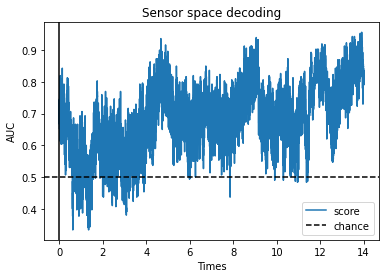

In [28]:
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
# here we use cv=3 just for speed
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=6)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

  0%|          | Fitting SlidingEstimator : 0/28673 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


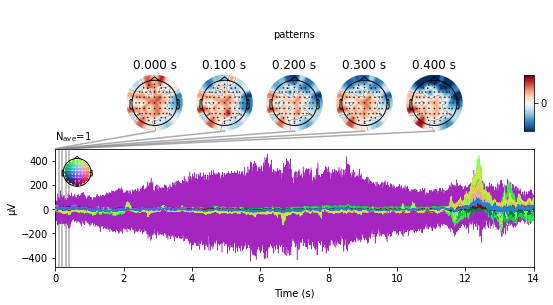

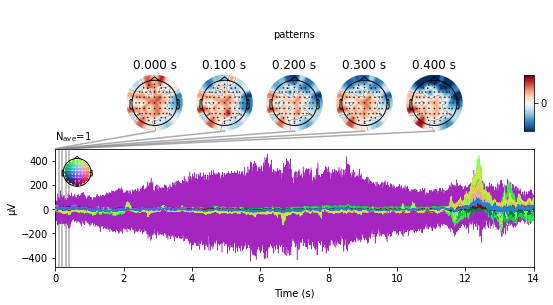

In [29]:
clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs')))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                           **joint_kwargs)

==========================  ID  ==========================


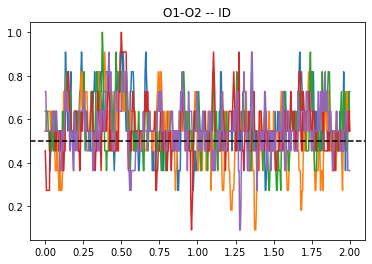

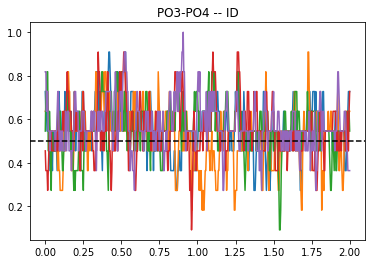

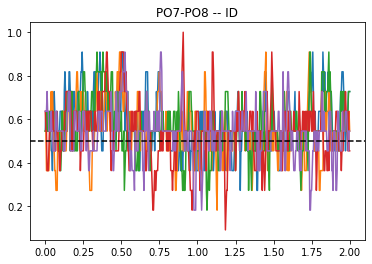

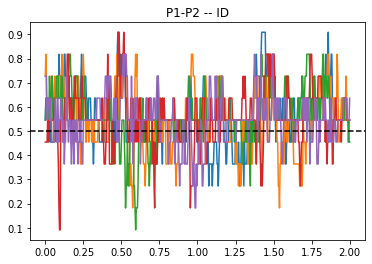

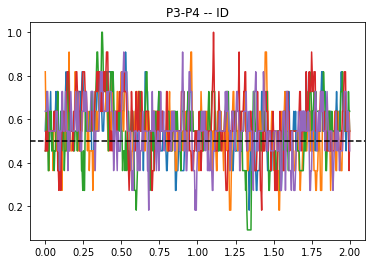

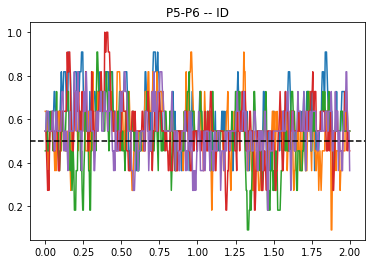

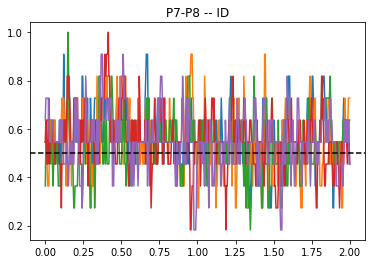

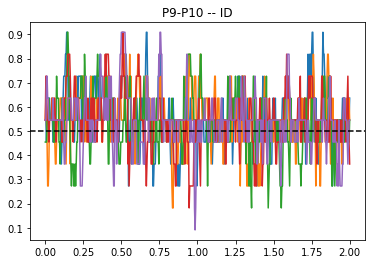

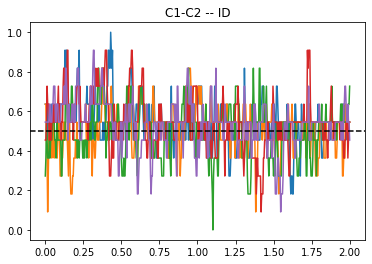

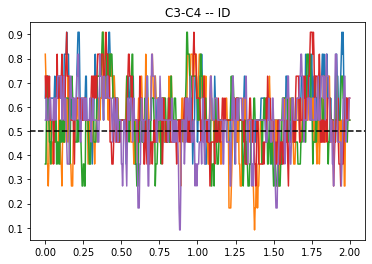

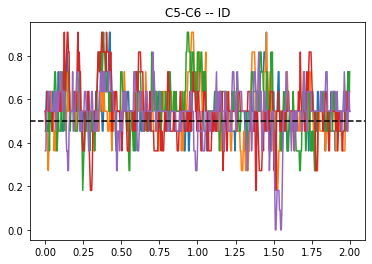

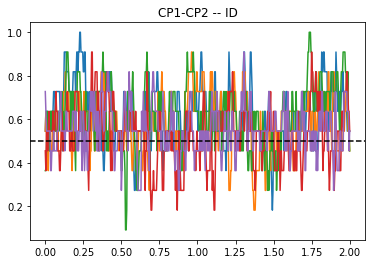

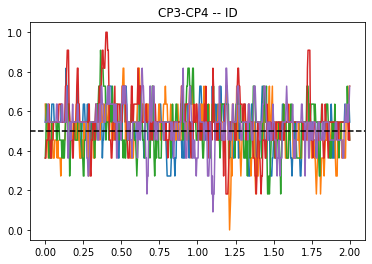

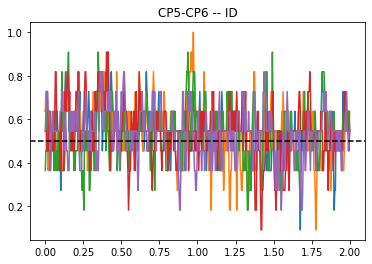

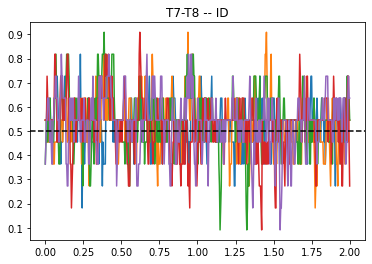

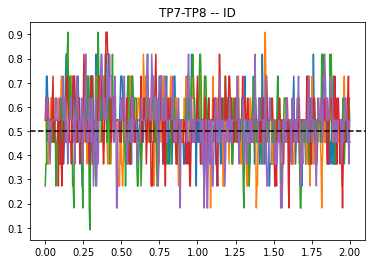

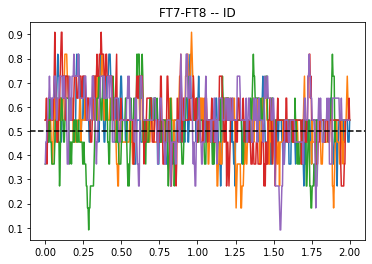

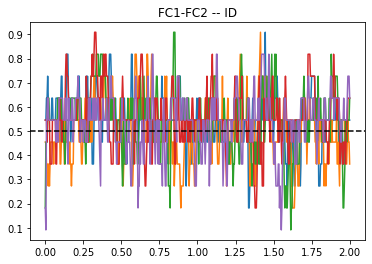

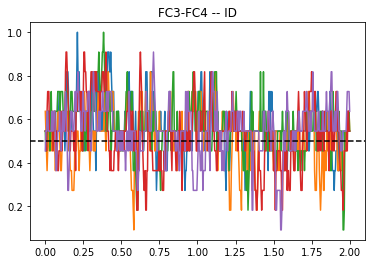

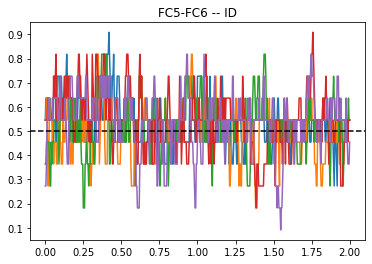

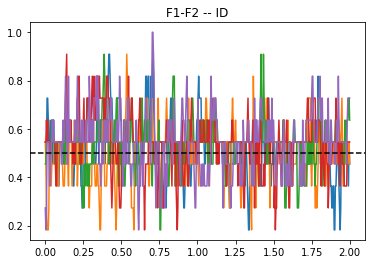

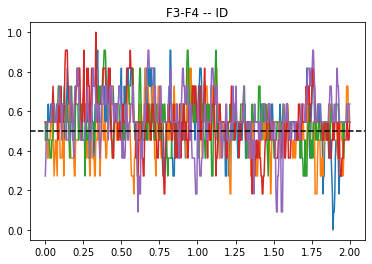

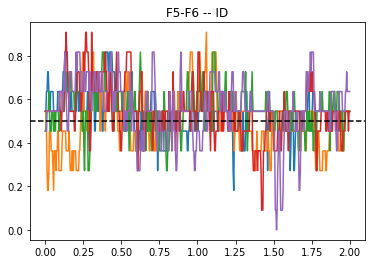

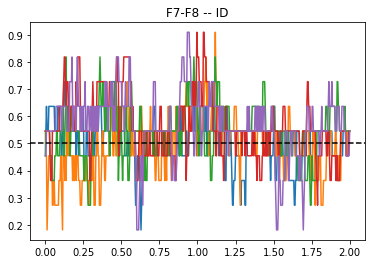

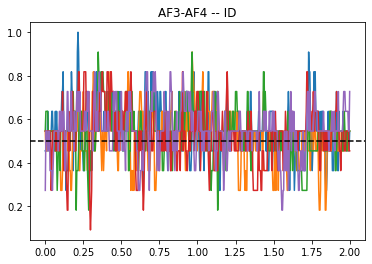

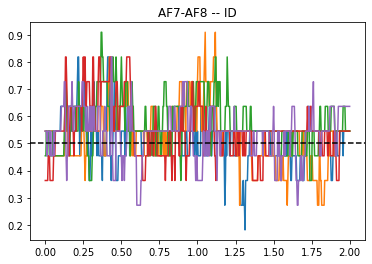

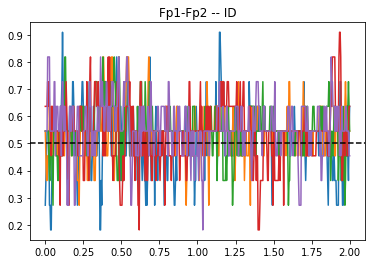

==========================  ID  ==========================


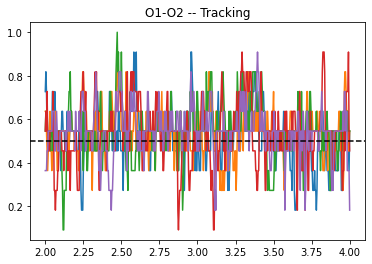

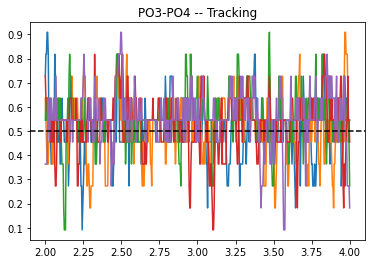

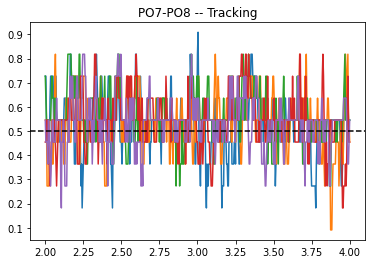

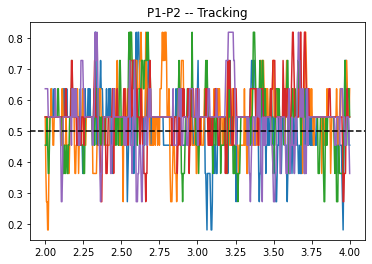

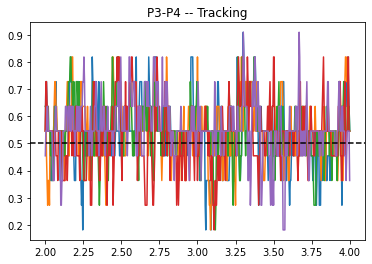

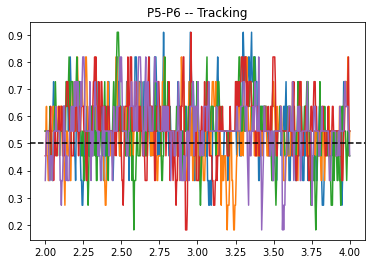

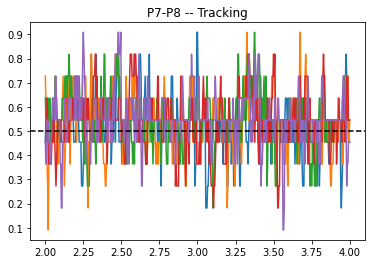

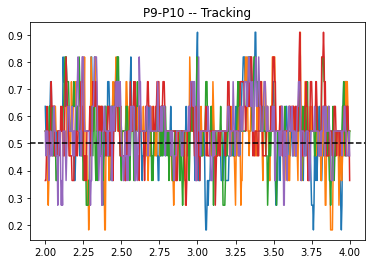

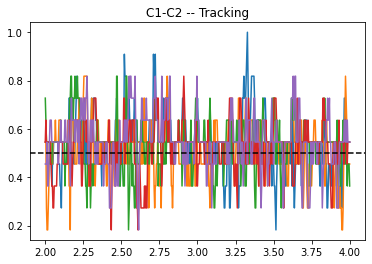

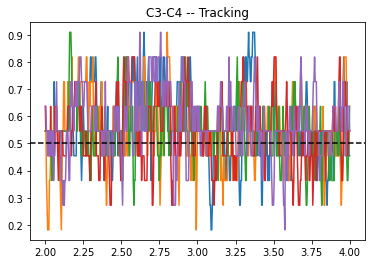

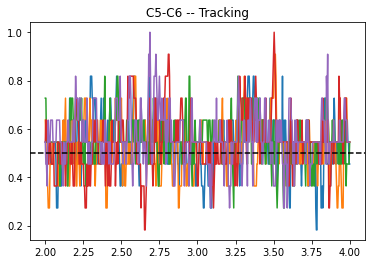

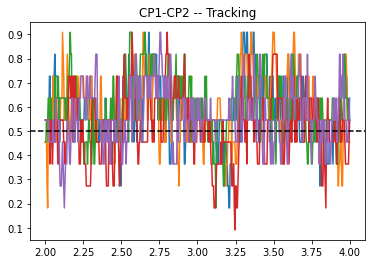

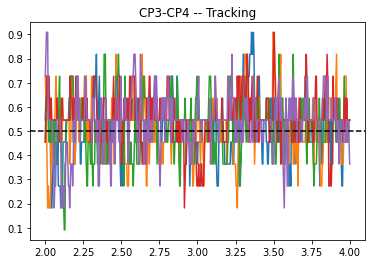

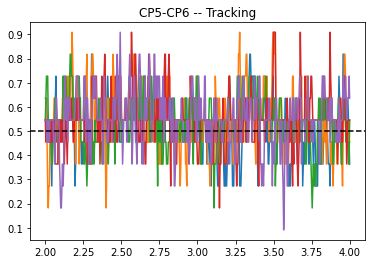

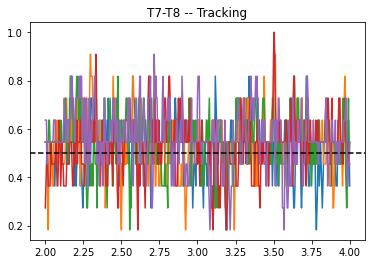

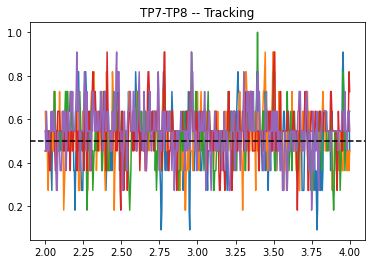

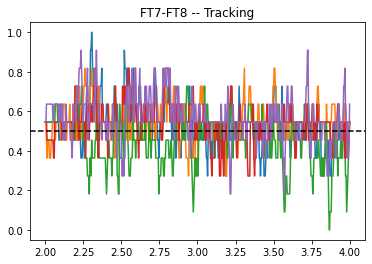

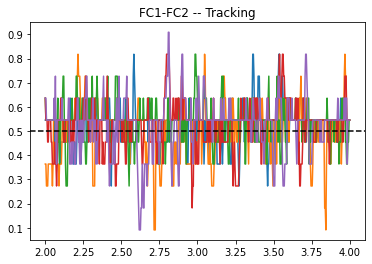

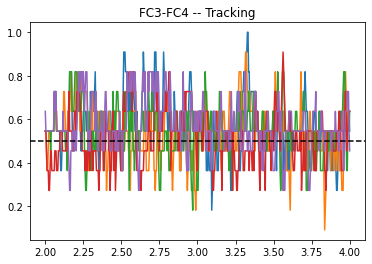

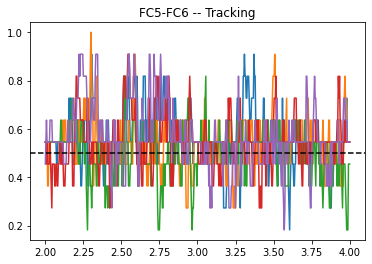

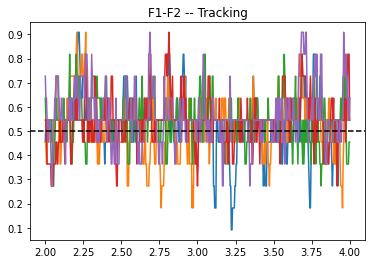

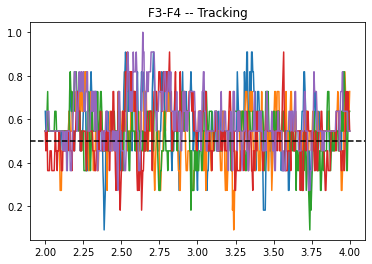

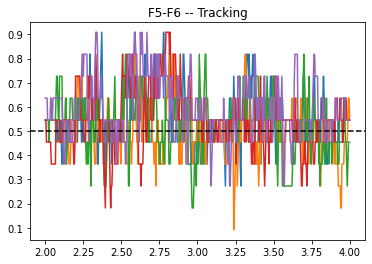

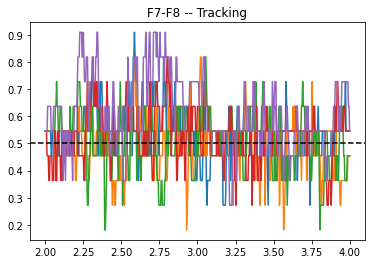

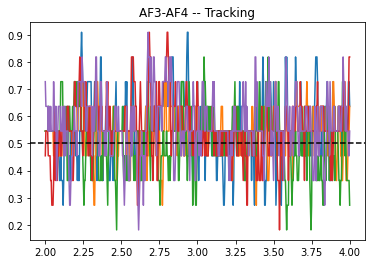

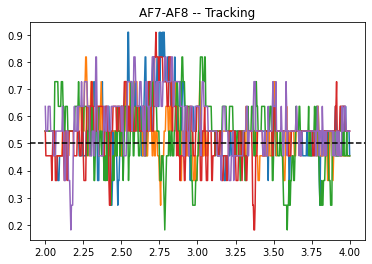

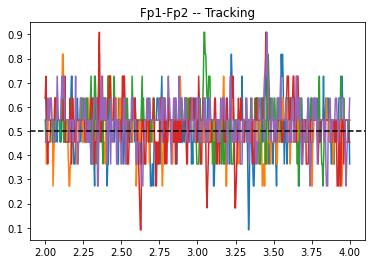

==========================  ID  ==========================


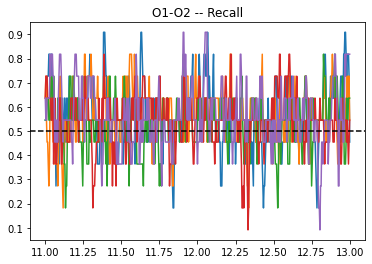

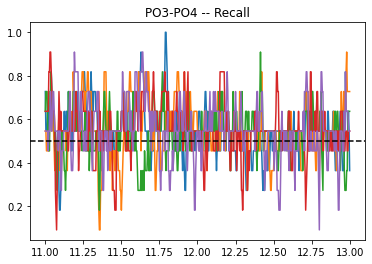

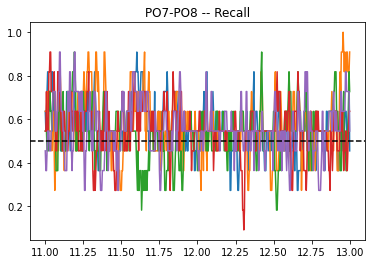

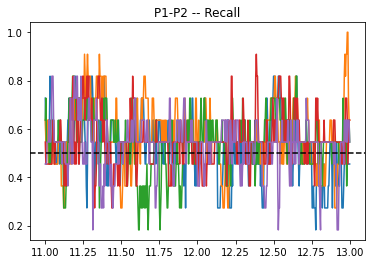

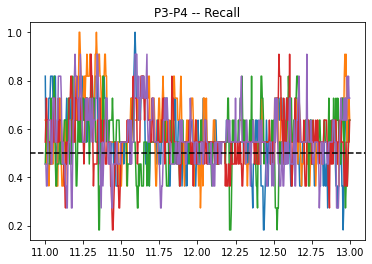

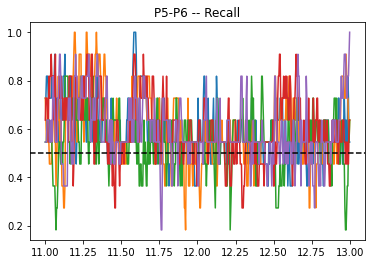

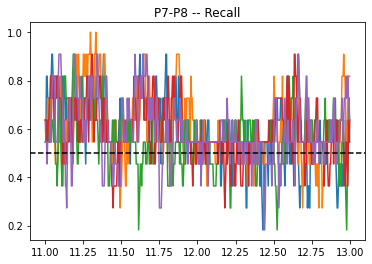

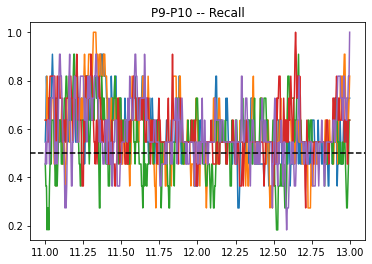

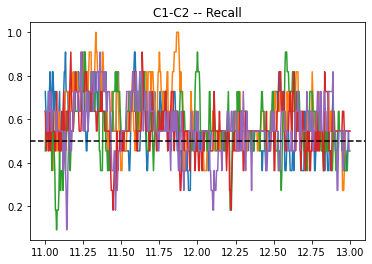

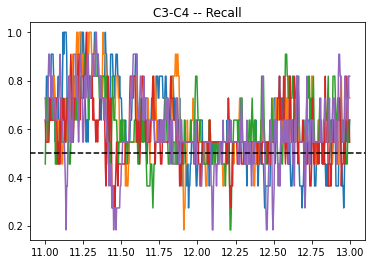

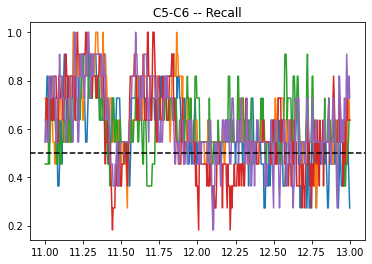

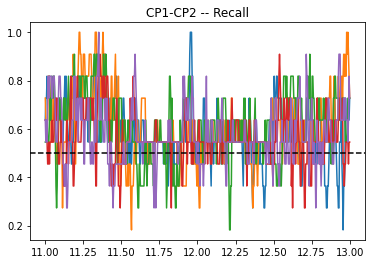

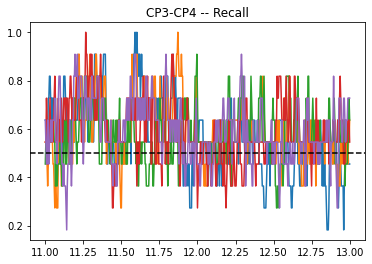

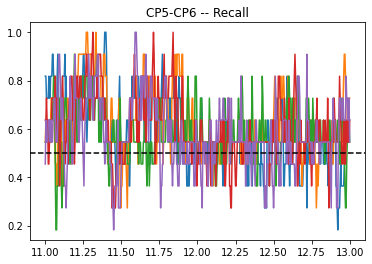

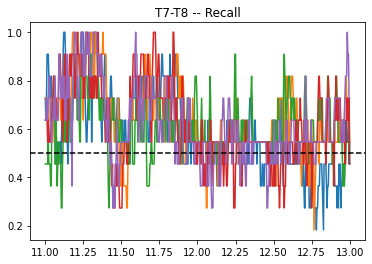

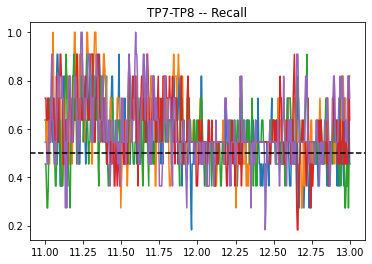

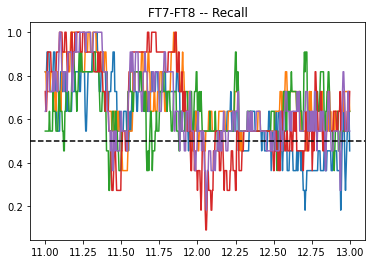

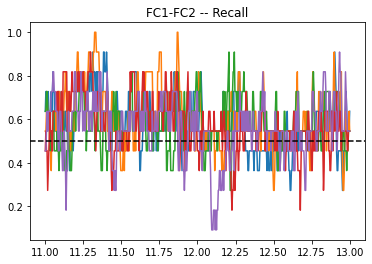

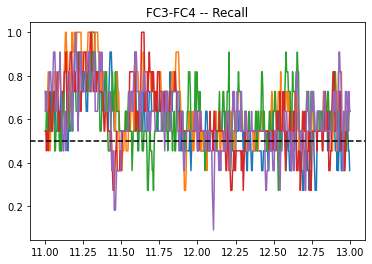

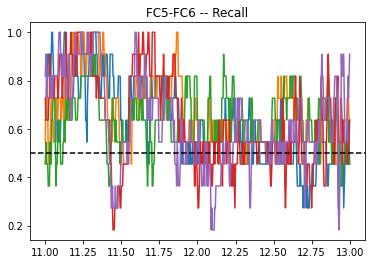

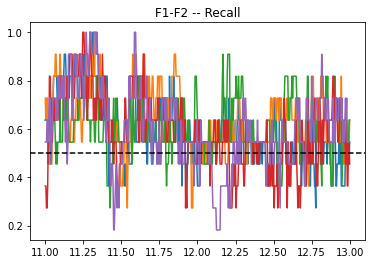

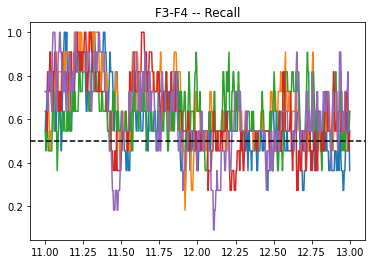

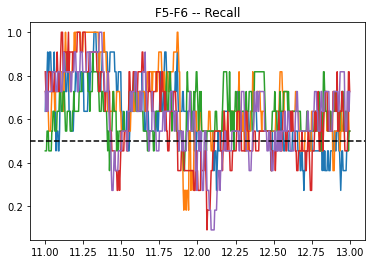

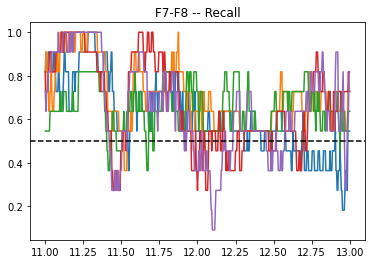

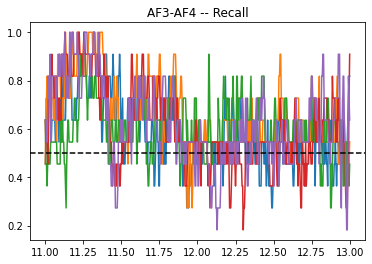

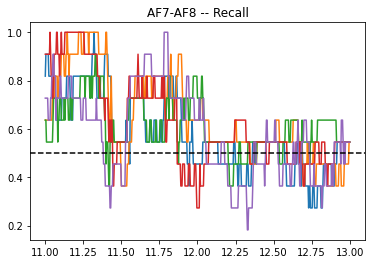

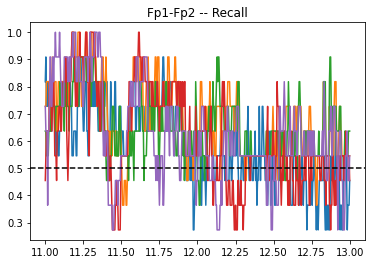

In [59]:
dir_path = "D:\\PhD\\NeuroTracker - Paper\\Exploratory\\"
with open(dir_path + "F12F2.pkl","rb") as f:
    data_pickle = pickle.load(f)
    
scores_dict = data_pickle['scores_dict']
time_limits = data_pickle['time_limits']
times = data_pickle['times']
for phase in scores_dict.keys():
    print('==========================  ID  ==========================')
    time_window = (times >= time_limits[phase][0]) & (times <= time_limits[phase][1])
    for ch_pair in scores_dict[phase].keys():
        plt.figure()
        for score in scores_dict[phase][ch_pair]:
            plt.plot(times[time_window], score)
        plt.axhline(0.5, linestyle='--', color='black')
        plt.title(f'{ch_pair} -- {phase}')
        plt.show()

In [65]:
dir_path = "D:\\PhD\\NeuroTracker - Paper\\Exploratory\\"

scores_dict_all = dict()

for filepath in glob.iglob(dir_path + '*.pkl'):
    filename = filepath[filepath.rfind('\\')+1:]
    print(f'Processing: {filename}')
    
    with open(filepath, "rb") as f:
        data_pickle = pickle.load(f)

    scores_dict = data_pickle['scores_dict']
    time_limits = data_pickle['time_limits']
    times = data_pickle['times']
        
    scores_dict_all[filename] = scores_dict
    
ch_pairs = scores_dict['ID'].keys()

Processing: F12F2.pkl
Processing: F12M1.pkl
Processing: F19M1.pkl
Processing: F26F2.pkl
Processing: F5M1.pkl
Processing: M22F2.pkl
Processing: M8M1.pkl
Processing: M8M2.pkl
Processing: S20M1.pkl
Processing: S21F1.pkl
Processing: T11F1.pkl
Processing: T16F2.pkl
Processing: T18F2.pkl
Processing: T18M1.pkl
Processing: T23F1.pkl
Processing: T23F2.pkl
Processing: T25F1.pkl
Processing: T9F2.pkl
Processing: W10F2.pkl
Processing: W17M2.pkl


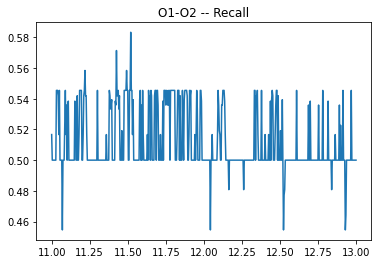

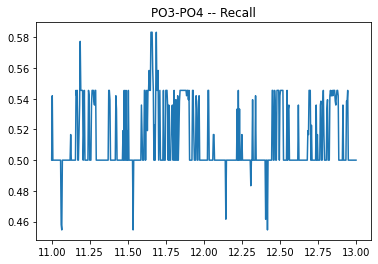

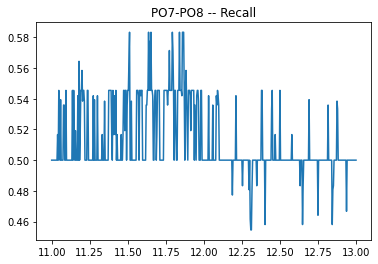

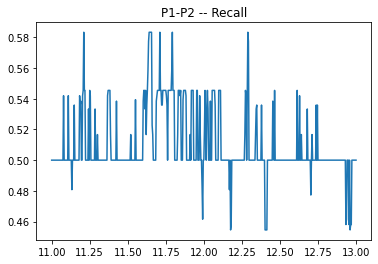

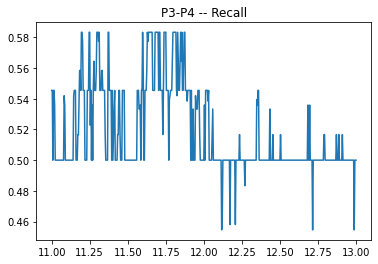

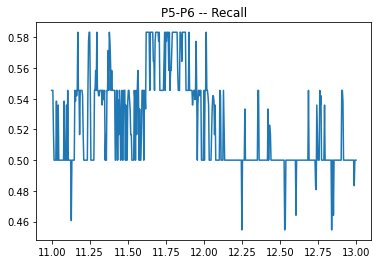

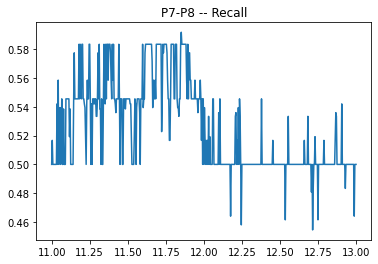

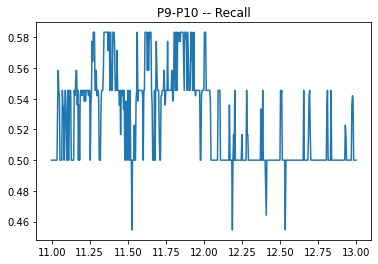

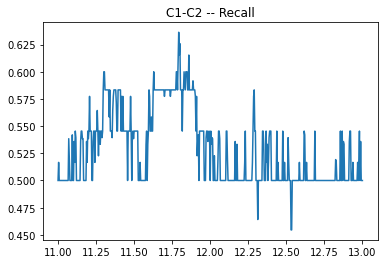

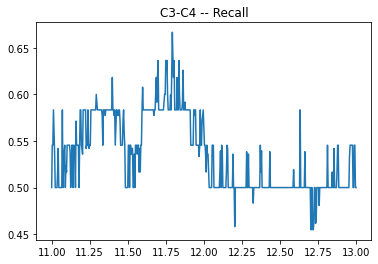

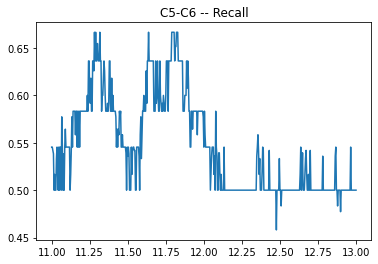

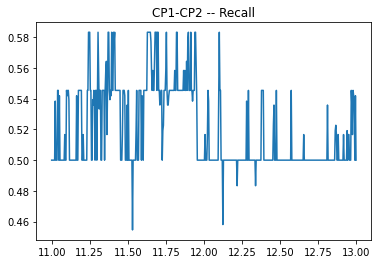

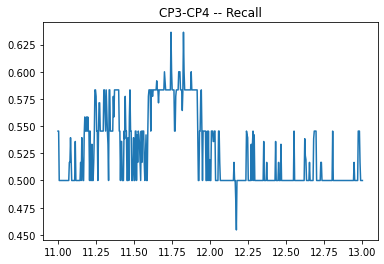

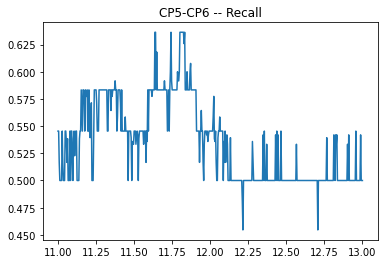

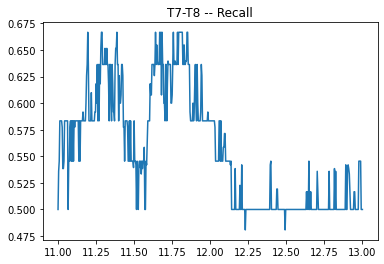

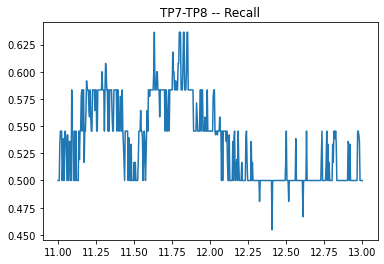

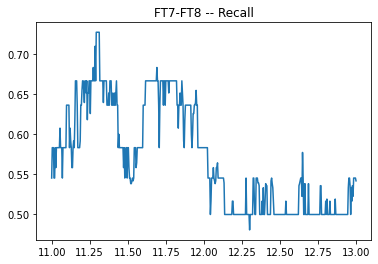

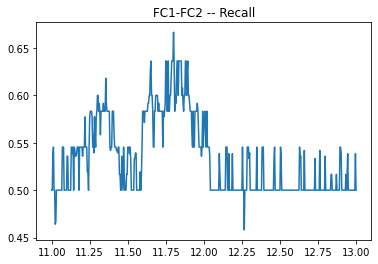

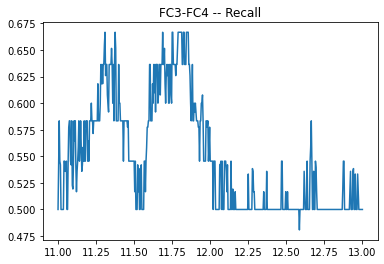

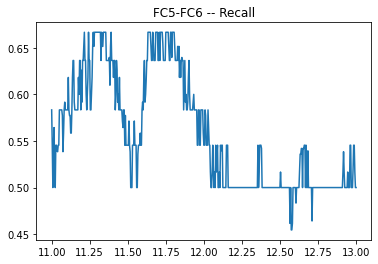

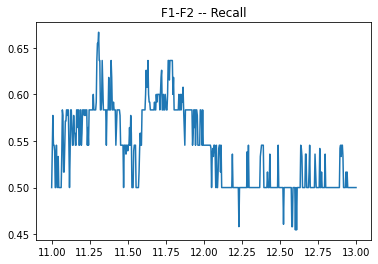

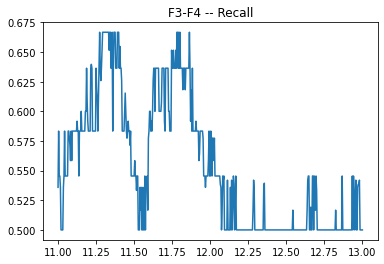

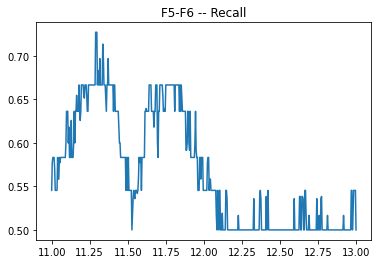

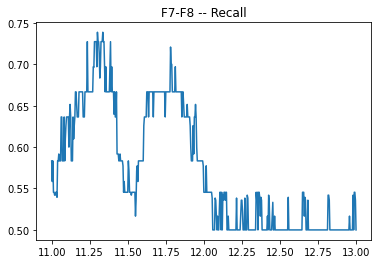

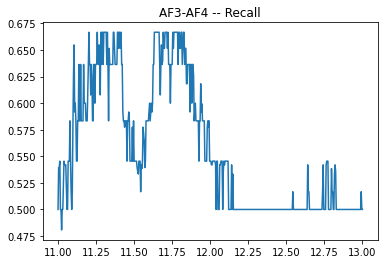

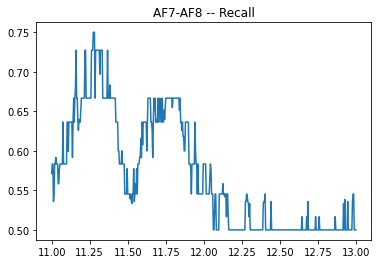

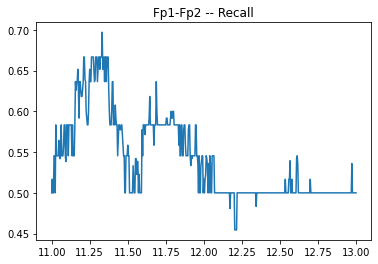

In [75]:
phases = ['ID', 'Tracking', 'Recall']

cur_phase = 'Recall'

time_window = (times >= time_limits[cur_phase][0]) & (times <= time_limits[cur_phase][1])
for ch_pair in ch_pairs:
    cur_scores = []
    for participant in scores_dict_all.keys():
        for score in scores_dict_all[participant][cur_phase][ch_pair]:
            cur_scores.append(score)
    plt.plot(times[time_window], np.median(np.stack(cur_scores), 0))
    plt.title(f'{ch_pair} -- {cur_phase}')
    plt.show()

In [91]:
phases = ['ID', 'Tracking', 'Recall']

cur_phase = 'Tracking'

time_window = (times >= time_limits[cur_phase][0]) & (times <= time_limits[cur_phase][1])
for participant in scores_dict_all.keys():
    str_channels = ''
    for ch_pair in ch_pairs:
        if np.any(scores_dict_all[participant][cur_phase][ch_pair] >= 0.9):
            str_channels = str_channels + ch_pair + '\t'
        #plt.plot(times[time_window], np.median(np.stack(cur_scores), 0))
        #plt.title(f'{ch_pair} -- {cur_phase}')
    #plt.show()
    print(str_channels + '\n')

O1-O2	PO3-PO4	PO7-PO8	P3-P4	P5-P6	P7-P8	P9-P10	C1-C2	C3-C4	C5-C6	CP1-CP2	CP3-CP4	CP5-CP6	T7-T8	TP7-TP8	FT7-FT8	FC1-FC2	FC3-FC4	FC5-FC6	F1-F2	F3-F4	F5-F6	F7-F8	AF3-AF4	AF7-AF8	Fp1-Fp2	

O1-O2	PO3-PO4	PO7-PO8	P1-P2	P3-P4	P5-P6	P7-P8	P9-P10	C1-C2	C3-C4	C5-C6	CP1-CP2	CP3-CP4	CP5-CP6	T7-T8	TP7-TP8	FT7-FT8	FC1-FC2	FC3-FC4	FC5-FC6	F1-F2	F3-F4	F5-F6	F7-F8	AF3-AF4	AF7-AF8	Fp1-Fp2	

O1-O2	PO3-PO4	PO7-PO8	P1-P2	P3-P4	P5-P6	P7-P8	P9-P10	C1-C2	C3-C4	C5-C6	CP1-CP2	CP3-CP4	CP5-CP6	T7-T8	TP7-TP8	FT7-FT8	FC1-FC2	FC3-FC4	FC5-FC6	F1-F2	F3-F4	F5-F6	F7-F8	AF3-AF4	AF7-AF8	Fp1-Fp2	

O1-O2	PO3-PO4	PO7-PO8	P1-P2	P3-P4	P5-P6	P7-P8	P9-P10	C1-C2	C3-C4	C5-C6	CP1-CP2	CP3-CP4	CP5-CP6	T7-T8	TP7-TP8	FT7-FT8	FC1-FC2	FC3-FC4	FC5-FC6	F1-F2	F3-F4	F5-F6	F7-F8	AF3-AF4	AF7-AF8	Fp1-Fp2	

O1-O2	PO3-PO4	PO7-PO8	P1-P2	P3-P4	P5-P6	P7-P8	P9-P10	C1-C2	C3-C4	C5-C6	CP1-CP2	CP3-CP4	CP5-CP6	T7-T8	TP7-TP8	FT7-FT8	FC1-FC2	FC3-FC4	FC5-FC6	F1-F2	F3-F4	F5-F6	F7-F8	AF3-AF4	AF7-AF8	Fp1-Fp2	

O1-O2	PO3-PO4	PO7-PO8	P1-P2	P3-P4	P5-P6	P7-P8	P9-P1

### if np.any(scores_dict_all[participant][cur_phase]['O1-O2'] >= 0.7):
    print('Yes')